In [11]:
from utils import feature_importances
import featuretools as ft
from featuretools.primitives import RollingMean, NumericLag
import woodwork as ww
from evalml import AutoMLSearch
from evalml.model_understanding import graph_prediction_vs_actual_over_time


import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error

In this demo, we'll work to predict future daily average temperatures using historical temperature data. This is a time series machine learning problem, which requires special considerations during preprocessing, feature engineering, and model building.

To highlight the proess through which we can solve a time series problem, we'll build three models.

First, we'll build a baseline model; this will highlight the unique constraints for data-splitting and allow us to understand the problem definition. Then, we'll explore time series feature engineering by generating features with Featuretools. Finally, we'll use EvalML's time series modeling to greatly simplify the process through which these models are built.

## Understanding Time Series Problems

Time series forecasting is different from other machine learning problems in that there is an inherent temporal ordering to the data. The ordering comes from a time index column, so at a specific point in time, we may have knowlege about earlier observations but not later ones. If the data is unordered, it’d be hard to see any overall trend or seasonality, but when sorted by date, any relationships that exist in the data can be seen and used when making predictions (winter is cold; summer is hot!). Notice how this is different from non-time series data, which can be presented in any order without having an impact on the resulting predictions.

Other demos in this repository explore this concept some. predict-remaining-useful-life, predict olympic medals, predict-appointment-noshow all have time indices that play a large roll in splitting the data for feature engineering. We can set a `cutoff_time` for feature engineering after which we do not have access to data. This is very useful for datasets that have multiple tables with relationships; we can build features from aggregations across tables. 

In this demo, we'll only have one table worth of data, but its temporal ordering means that we have access to a column's own historical data for feature engineering. When trying to determine tomorrow's temperature, knowing today's temperature may be the most predictive piece of information we can get. Realistically, we may not have data from so recent a time, but the concept stands; utilizing the most recent information we have is the bread and butter of time series modeling.

In a time series problem, our task is to predict the future values of our target variable. If we engineer the right features, we can use normal regression models; but we need to account for the temporal ordering of the data. 

## Load in Data

We’ll demonstrate how to build a time series model using the DailyDelhiClimateTrain dataset, which contains a `meantemp` target variable and a `date` time index. There are other columns, but for the purposes of simplicity, we'll only work with the target and time index columns. To include the others would bring this demo into the sphere of multivariate time series modeling, which brings its own host of complexity.

In [12]:
file_name = "DailyDelhiClimateTrain"
df = pd.read_csv(f"data/{file_name}.csv")

df

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


Now, we'll do a quick sanity check that the data has some temporal pattern that we can exploit for modeling purposes.

First, we'll use a Woodwork method to check whether there is any column with a uniform sampling frequency. This is important, because it means that there is a constant amount of time between observations. A dataset that does not have a uniform sampling frequency can still be used for time series modeling, but the existence of that frequency is a good indicator that this dataset is ripe for time series modeling. For columns that have multiple datetime columns, checking for a frequency is also a good indicator for which could be the time index.

In [13]:
df.ww.init()
df.ww.infer_temporal_frequencies()

{'date': 'D'}

Indeed, one of the columns, `date`, has a daily frequency; we'll move forward with it as our time index.

Now, we’ll graph the data.

<AxesSubplot:xlabel='date'>

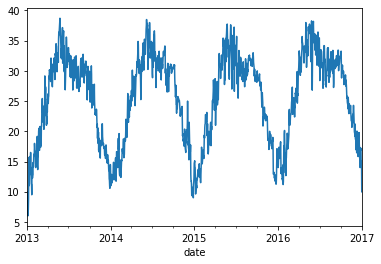

In [14]:
ts = df['meantemp']
ts.index = df['date']
ts.plot()

We can see a strong seasonality, which makes sense for temperature! In many places, the time of the year is indicative of what the weather will look like. Now, we'll build a baseline model that uses the most recently available data. 

But how do we define what data we have access to when? In many scenarios, this might be be determined by quickly we can get access to recent observations. Since we're building a model using training and test data that we'll have access to right now, we'll need to set some parameters arbitrarily. But these parameters will let us define the problem more formally. We'll stick with these definitions problem configuration throughout the rest of the demo. 

## Problem Configuration
Here are a few concepts that give us our official problem configuration:

**forecast_horizon**: The number of time periods we are trying to forecast. In this example, we’re interested in predicting the mean temperature for the next 5 days, so the value is 5.

**gap**: The number of time periods between the end of the training set and the start of the test set. We’re going to make predictions using data from three days prior to each observation.

**max_delay**: The maximum number of rows to look in the past from the current row in order to compute features. Here, we’ll use a max delay of 20.

**time_index**: The column of the training dataset that contains the date corresponding to each observation. Here, it's the `date` column.

Our problem can then be described as trying to predict the mean temperature over the next five days using temperature data from 20 days prior. 

In [15]:
# The only columns we'll want to use for modeling - makes this a univariate problem
time_index = "date"
target_col = 'meantemp'

# parameters as evalml uses them 
gap = 3
max_delay = 20
forecast_horizon = 5

Since we do not want to complicate the solition by performing multivariate time series modeling, we'll only use the time index column and target column for the rest of this demo. 

In [16]:
univariate_df = df[[time_index, target_col]]

Additionally, we'll want to have our data split up into training and testing data. We'll use the same split for both our baseline and Featuretools runs. We're leaving a `gap` number of observations between the train and test sets in order to not have the test dataset's lag feature use values that are technically before the test set begins or inside of the training set. 

In [17]:
split_point = int(univariate_df.shape[0]*.8)

# leave gap observations between training and test datasets
training_data = univariate_df[:split_point]
test_data = univariate_df[(split_point + gap):]

training_data

,date,meantemp
0,2013-01-01,10.000000
1,2013-01-02,7.400000
2,2013-01-03,7.166667
3,2013-01-04,8.666667
4,2013-01-05,6.000000
...,...,...
1164,2016-03-10,25.562500
1165,2016-03-11,25.066667
1166,2016-03-12,24.562500
1167,2016-03-13,24.250000


# Baseline Run

Our baseline run will only include one feature that is a delayed value from the `meantemp` column. That delayed value will be the first known value for each observation. 

### Feature Engineering

In [21]:
# Add a delayed target feature to both traning and test data
target_lag_training = training_data[target_col].shift(forecast_horizon + gap + 1)
target_lag_training.name = 'target_lag'
baseline_training = pd.concat([training_data, target_lag_training], axis=1)

target_lag_test = test_data[target_col].shift(forecast_horizon + gap + 1)
target_lag_test.name = 'target_lag'
baseline_test = pd.concat([test_data, target_lag_test], axis=1)

baseline_training

,date,meantemp,target_lag
0,2013-01-01,10.000000,NaN
1,2013-01-02,7.400000,NaN
2,2013-01-03,7.166667,NaN
3,2013-01-04,8.666667,NaN
4,2013-01-05,6.000000,NaN
...,...,...,...
1164,2016-03-10,25.562500,24.916667
1165,2016-03-11,25.066667,24.933333
1166,2016-03-12,24.562500,26.000000
1167,2016-03-13,24.250000,27.312500


### Format data for modeling

We won't want the datetime column in our data for modeling, we also need to remove the null values that were introduced in the delayed target feature, and last we need to pull the target column out. 

In [22]:
def remove_nans(time_target_fs, target_col):
    # remove nans
    max_nans = 0
    for col in time_target_fs.columns:
        max_nans = max(time_target_fs[col].isna().sum(), max_nans)

    if max_nans:
        return time_target_fs.iloc[max_nans:]
    
    return time_target_fs

# Get rid of the time index column for modeling
baseline_training.drop(time_index, axis=1, inplace=True)
baseline_test.drop(time_index, axis=1, inplace=True)

# The lag feature introduces nans, so we remove those rows and pull out the target
X_train = remove_nans(baseline_training, target_col)
y_train = X_train.pop(target_col)

X_test = remove_nans(baseline_test, target_col)
y_test = X_test.pop(target_col)

### Build The Model

In [23]:
reg = RandomForestRegressor(n_estimators=100)
reg.fit(X_train, y_train)

preds = reg.predict(X_test)
scores = median_absolute_error(preds, y_test)
print('Median Abs Error: {:.2f}'.format(scores))

high_imp_feats = feature_importances(X_train, reg, feats=10)

Median Abs Error: 1.99
1: target_lag [1.000]
-----



Next, we're going to expand our feature engineering step using Featuretools' deep feature synthesis. We'll utilize a few time-series specific primitives as well as some datetime primitives. 

# Feature Engineering Run 

We're going to use the same split that we used for the baseline run, so we'll work with the `training_data` and `test_data` dataframes from before.

### Feature Engineering with Featuretools

In order to use DFS, we need to set up `EntitySet` objects for both the training and testing data. Since our dataset only includes one table, this will be a quick process. 

In [24]:
training_es = ft.EntitySet()
training_es.add_dataframe(training_data.copy(), 
                 dataframe_name='temperatures', 
                 index='id', 
                 make_index=True, 
                 time_index=time_index)

Entityset: None
  DataFrames:
    temperatures [Rows: 1169, Columns: 3]
  Relationships:
    No relationships

In [25]:
test_es = ft.EntitySet()
test_es.add_dataframe(test_data.copy(), 
                 dataframe_name='temperatures', 
                 index='id', 
                 make_index=True, 
                 time_index=time_index)

Entityset: None
  DataFrames:
    temperatures [Rows: 290, Columns: 3]
  Relationships:
    No relationships

Now, we'll set up our primitives for DFS. There will be three types of primitives:

- Datetime primitives - these extract features from datetime columns
- Rolling primitives - these perform aggregate calculations over rolling windows. Parameters can be set that allow an observation's window to be entirely before the observation occurs, which is important for not exposing our target variable. 
- Lagging primitives - these are primitive versions of the delayed target feature from the baseline run. We'll define multiple of these with different delays.

We use the `gap`, `forecast_horizon`, and `max_delay` parameters from before to set our primitive parameters.

In [53]:
# Rolling gap is comprised of both our `gap` parameter and the forecast horizon, 
# because they determine the first observation we have access to. We'll also use them in defining our Numeric Lag primitives
rolling_gap = forecast_horizon + gap

# The .25 is a heuristic to only use a portion of the max_delay for the window length
rolling_window_length = int(.25*max_delay) + 1 # a quarter is a heuristic here 
# Min periods is a pandas parameter, and it just stops us from including partial calculations before the windows have 
# all the possible observations
rolling_min_periods = int(.25*max_delay) + 1

datetime_primitives = [ 'Month', 'Hour', "Year"]
delaying_primitives = [NumericLag(periods=t + forecast_horizon + gap) for t in range(forecast_horizon + gap + 1)]
rolling_mean_primitive = RollingMean(rolling_window_length, 
                                               gap=rolling_gap,
                                              min_periods=rolling_min_periods)



In [54]:
train_fm, features = ft.dfs(entityset=training_es, 
               target_dataframe_name='temperatures', 
               max_depth=1,
               trans_primitives = datetime_primitives 
                            + delaying_primitives 
                            + [ rolling_mean_primitive ]
              )

Again, we'll need to remove the null values introduced by the delaying primitives and the rolling mean primitive. 

In [55]:
X_train = remove_nans(train_fm, target_col)
y_train = X_train.pop(target_col)

X_train

,HOUR(date),MONTH(date),"NUMERIC_LAG(date, meantemp, periods=10)","NUMERIC_LAG(date, meantemp, periods=11)","NUMERIC_LAG(date, meantemp, periods=12)","NUMERIC_LAG(date, meantemp, periods=13)","NUMERIC_LAG(date, meantemp, periods=14)","NUMERIC_LAG(date, meantemp, periods=15)","NUMERIC_LAG(date, meantemp, periods=16)","NUMERIC_LAG(date, meantemp, periods=8)","NUMERIC_LAG(date, meantemp, periods=9)","ROLLING_MEAN(date, meantemp, window_length=6, gap=8, min_periods=6)",YEAR(date)
id,,,,,,,,,,,,,
16,0,1,7.000000,7.000000,6.000000,8.666667,7.166667,7.400000,10.000000,14.000000,8.857143,8.587302,2013
17,0,1,8.857143,7.000000,7.000000,6.000000,8.666667,7.166667,7.400000,11.000000,14.000000,8.976190,2013
18,0,1,14.000000,8.857143,7.000000,7.000000,6.000000,8.666667,7.166667,15.714286,11.000000,10.595238,2013
19,0,1,11.000000,14.000000,8.857143,7.000000,7.000000,6.000000,8.666667,14.000000,15.714286,11.761905,2013
20,0,1,15.714286,11.000000,14.000000,8.857143,7.000000,7.000000,6.000000,15.833333,14.000000,13.234127,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1164,0,3,23.875000,23.000000,22.800000,22.800000,22.562500,21.687500,21.428571,24.933333,24.916667,23.720833,2016
1165,0,3,24.916667,23.875000,23.000000,22.800000,22.800000,22.562500,21.687500,26.000000,24.933333,24.254167,2016
1166,0,3,24.933333,24.916667,23.875000,23.000000,22.800000,22.800000,22.562500,27.312500,26.000000,25.006250,2016


Now, we'll use the feature definitions from the DFS run on the test data, producing the test feature matrix.

In [56]:
test_fm = ft.calculate_feature_matrix(features, test_es)

X_test = remove_nans(test_fm, target_col)
y_test = X_test.pop(target_col)

X_test

,HOUR(date),MONTH(date),"NUMERIC_LAG(date, meantemp, periods=10)","NUMERIC_LAG(date, meantemp, periods=11)","NUMERIC_LAG(date, meantemp, periods=12)","NUMERIC_LAG(date, meantemp, periods=13)","NUMERIC_LAG(date, meantemp, periods=14)","NUMERIC_LAG(date, meantemp, periods=15)","NUMERIC_LAG(date, meantemp, periods=16)","NUMERIC_LAG(date, meantemp, periods=8)","NUMERIC_LAG(date, meantemp, periods=9)","ROLLING_MEAN(date, meantemp, window_length=6, gap=8, min_periods=6)",YEAR(date)
id,,,,,,,,,,,,,
16,0,4,28.133333,26.200000,25.062500,26.625000,27.133333,26.785714,26.187500,24.666667,29.875000,26.760417,2016
17,0,4,29.875000,28.133333,26.200000,25.062500,26.625000,27.133333,26.785714,26.250000,24.666667,26.697917,2016
18,0,4,24.666667,29.875000,28.133333,26.200000,25.062500,26.625000,27.133333,25.933333,26.250000,26.843056,2016
19,0,4,26.250000,24.666667,29.875000,28.133333,26.200000,25.062500,26.625000,27.125000,25.933333,26.997222,2016
20,0,4,25.933333,26.250000,24.666667,29.875000,28.133333,26.200000,25.062500,29.571429,27.125000,27.236905,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,0,12,16.083333,17.500000,15.833333,18.166667,18.555556,19.050000,19.909091,19.800000,17.857143,17.540079,2016
286,0,12,17.857143,16.083333,17.500000,15.833333,18.166667,18.555556,19.050000,18.050000,19.800000,17.520635,2016
287,0,12,19.800000,17.857143,16.083333,17.500000,15.833333,18.166667,18.555556,17.285714,18.050000,17.762698,2016


### Model Building

In [58]:
reg = RandomForestRegressor(n_estimators=100)
reg.fit(X_train, y_train)

preds = reg.predict(X_test)
scores = median_absolute_error(preds, y_test)
print('Median Abs Error: {:.2f}'.format(scores))

high_imp_feats = feature_importances(X_train, reg, feats=100)


Median Abs Error: 1.60
1: NUMERIC_LAG(date, meantemp, periods=8) [0.454]
2: ROLLING_MEAN(date, meantemp, window_length=6, gap=8, min_periods=6) [0.350]
3: NUMERIC_LAG(date, meantemp, periods=9) [0.062]
4: MONTH(date) [0.057]
5: NUMERIC_LAG(date, meantemp, periods=10) [0.015]
6: NUMERIC_LAG(date, meantemp, periods=16) [0.011]
7: NUMERIC_LAG(date, meantemp, periods=15) [0.010]
8: NUMERIC_LAG(date, meantemp, periods=13) [0.010]
9: NUMERIC_LAG(date, meantemp, periods=14) [0.008]
10: NUMERIC_LAG(date, meantemp, periods=12) [0.008]
11: NUMERIC_LAG(date, meantemp, periods=11) [0.008]
12: YEAR(date) [0.006]
13: HOUR(date) [0.000]
-----



## Use Time Series Regression Problem From EvalML
We will now use EvalML to build a model that is very similar to the one we just built with the help of Featuretools. EvalML's time series regression problem type does the same feature engineering that we just did under the hood. That, along with some other optimizations and the fact that we run multiple pipelines shows the power of EvalML.

### Data Splitting

Here, we can use EvalML's time series data splitting capabilities, which will leave us with data that has its time index in tact.

In [59]:
import evalml

univariate_df = df[[time_index, target_col]]

X = univariate_df
y = univariate_df.pop(target_col)

X_train, X_test, y_train, y_test = evalml.preprocessing.split_data(X, y,
                                                                   problem_type='time series regression',
                                                                   test_size=.2,
                                                                  problem_configuration={"gap": gap, 
                                                                                         "max_delay": max_delay,
                                                                                         "forecast_horizon": forecast_horizon,
                                                                                         "time_index": time_index},)

X_train

,date
0,2013-01-01
1,2013-01-02
2,2013-01-03
3,2013-01-04
4,2013-01-05
...,...
1164,2016-03-10
1165,2016-03-11
1166,2016-03-12
1167,2016-03-13


### Model Building 
Now we can perform AutoMLSearch, which will provide us with six pipelines, one of which is the same as our baseline pipeline from above! 

In [33]:
from evalml import AutoMLSearch

automl = AutoMLSearch(X_train, y_train, problem_type="time series regression",
                      max_batches=1,
                      problem_configuration={"gap": gap, 
                                             "max_delay": max_delay,
                                             "forecast_horizon": forecast_horizon, 
                                             "time_index": time_index},
                      allowed_model_families=["xgboost", "random_forest", "linear_model", "extra_trees",
                                              "decision_tree"],
                      objective='MedianAE'
                      )
automl.search()

Time series support in evalml is still in beta, which means we are still actively building its core features. Please be mindful of that when running search().
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.504e+02, tolerance: 1.058e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.686e+03, tolerance: 3.066e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.828e+03, tolerance: 4.692e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.666e+03, tolerance: 6.109e+00


In [35]:
automl.rankings

,id,pipeline_name,search_order,mean_cv_score,standard_deviation_cv_score,validation_score,percent_better_than_baseline,high_variance_cv,parameters
0,1,Elastic Net Regressor w/ Imputer + Time Series...,1,1.735829,0.295337,1.735829,9.435011,False,{'Imputer': {'categorical_impute_strategy': 'm...
1,5,Extra Trees Regressor w/ Imputer + Time Series...,5,1.798169,0.409076,1.798169,6.182511,False,{'Imputer': {'categorical_impute_strategy': 'm...
2,3,Random Forest Regressor w/ Imputer + Time Seri...,3,1.826079,0.432566,1.826079,4.726298,False,{'Imputer': {'categorical_impute_strategy': 'm...
3,0,Time Series Baseline Regression Pipeline,0,1.916667,0.314576,1.916667,0.000000,False,{'Time Series Featurizer': {'time_index': 'dat...
4,2,XGBoost Regressor w/ Imputer + Time Series Fea...,2,1.976012,0.429196,1.976012,-3.096295,False,{'Imputer': {'categorical_impute_strategy': 'm...
5,4,Decision Tree Regressor w/ Imputer + Time Seri...,4,2.134427,0.469706,2.134427,-11.361431,False,{'Imputer': {'categorical_impute_strategy': 'm...


In [36]:
pipeline = automl.best_pipeline
pipeline.feature_importance

,feature,importance
0,target_rolling_mean,-4.902489
1,target_delay_8,3.372342
2,target_delay_11,1.873694
3,date_month,-1.457329
4,target_delay_12,1.328903
5,target_delay_17,1.252257
6,target_delay_9,1.238030
7,target_delay_10,1.130770
8,target_delay_13,1.018069
9,target_delay_15,0.599405


Look at how similar the order of features in the feature importance dataframe are!

Now, we'll explore the pipelines a bit more. First, we'll look at the best pipeline and show a graph of the predictions it makes over time. Then we'll do the same for the baseline pipeline. 

In [62]:
pipeline.fit(X_train, y_train)

best_pipeline_score = pipeline.score(X_test, y_test, ['MedianAE'], X_train, y_train)['MedianAE']
best_pipeline_score

/Users/tamar.grey/.pyenv/versions/3.8.2/envs/evalml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.666e+03, tolerance: 6.109e+00



1.4104719198005

In [63]:
fig = graph_prediction_vs_actual_over_time(pipeline, X_test, y_test, X_train, y_train, dates=X_test['date'])
fig

In [64]:
baseline = automl.get_pipeline(0)
baseline.fit(X_train, y_train)
naive_baseline_score = baseline.score(X_test, y_test, ['MedianAE'], X_train, y_train)['MedianAE']
naive_baseline_score

2.0249999999999986

In [65]:
fig = graph_prediction_vs_actual_over_time(baseline, X_test, y_test, X_train, y_train, dates=X_test['date'])
fig